## Test fonction run exp

### 1. Imports

In [3]:
import torch
import math
import config as config_
from importlib import reload
import matplotlib.pyplot as plt

In [4]:
import stat_reliability_measure.dev.torch_utils as t_u
from dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from config import Exp2Config
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
from dev.utils import range_vars,simple_vars
import pandas as pd
import os 


### 2. Model & Data load

In [5]:
reload(config_)

<module 'config' from '/home/karim-tito/stat_reliability_measure/config.py'>

In [6]:
config = Exp2Config(method_name="amls_webb")

In [7]:
config.update()
os.rmdir(config.exp_log_path)

input_shape:(1, 28, 28)


In [8]:
model=config.model

In [9]:
X,y = config.X[:1], config.y[:1]

In [10]:
config.sample_accuracy

0.9921875

## 3. Experiments with MALA-SMC, ours implementation and Webb's implementation of AMLS algorithm

In [11]:
epsilon_range=[0.19]
dataset='mnist'
n_rep = 100 
method_ref='MALA_SMC'
N_ref = 4000
T_ref = 50
ess_ref = 0.9
alpha_ref = 0.2

In [14]:
p_ref, dict_out = run_exp.run_stat_rel_exp(model=model,X=X,y=y, 
                                                repeat_exp=True,
                                             method='mala', dataset_name=dataset,n_rep=5,
                                epsilon_range=epsilon_range, update_aggr_res=True ,track_accept=False,
                                N_range=[N_ref], T_range =[T_ref],ess_alpha = ess_ref,alpha=alpha_ref)

[[4000], [50], [0.9], [0.2], [1]]
{'N_range': [4000], 'T_range': [50], 'ess_alpha_range': [0.9], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.19,N: 4000: T: 50: ess_alpha: 0.9: alpha: 0.2: L: 1


100%|██████████| 5/5 [00:57<00:00, 11.53s/it]


mean est:3.326648838992696e-05, std est:4.668333740153764e-06
mean calls:9985351.8
std. re.:4218.402133275881
std. rel. adj.:42122229334.630165


In [15]:
agg_res_df = pd.read_csv('../../logs/exp_2_mnist/aggr_res.csv')
ref_exp = utils.get_sel_df(df=agg_res_df, triplets=[('method_name',method_ref,'='),
                                                    ('epsilon',epsilon_range[0],'='),
        ('N',N_ref,'='),('T',T_ref,'='),('alpha',alpha_ref,'='), ])
p_ref,std_ref =ref_exp['mean_est'].values[0], ref_exp['std_est'].values[0]
p_ref,std_ref

(2.7631995908450336e-05, 3.096394561065395e-06)

In [30]:
ref_exp

,method_name,gaussian_latent,N,rho,n_rep,T,epsilon,alpha,min_rate,mean_time,...,steps,tol,num_iter,stepsize,random_init,search_method,sigma_init,requires_h,batch_size,track_advs
148,MALA_SMC,True,4000.0,NaN,5,50.0,0.19,0.2,0.15,11.907064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(mc_config)
reload(mc_pyt)


<module 'stat_reliability_measure.dev.mc.mc_pyt' from '/home/karim-tito/stat_reliability_measure/dev/mc/mc_pyt.py'>

In [16]:
p_fail_webb,dict_out=run_exp.run_stat_rel_exp(model=model,method='amls_webb',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=10, update_aggr_res=False, 
                         N_range=[3000],T_range=[100,],ratio_range=[0.5,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0 ,p_ref=p_ref
 )
exp_config,method_config_webb, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_webb=dict_out['results_df']
print(f"p_fail_webb={p_fail_webb}")

[[3000], [100], [0.5]]
Running reliability experiments on architecture custom trained on mnist.
Testing uniform noise pertubation with epsilon in [0.19]
{'N_range': [3000], 'T_range': [100], 'ratio_range': [0.5]}
Starting MLS_Webb simulation 1/1, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 100: ratio: 0.5


100%|██████████| 10/10 [01:51<00:00, 11.18s/it]


mean est:6.280589497108717e-06, std est:1.931128309624201e-06
mean calls:5423700.0
std. re.:48956.494549193034
std. rel. adj.:265525339486.45825
mean rel. error:0.7727059052151929
std rel. error:0.06988739850796045
stat performance (per 1k calls):379.0482832876251
p_fail_webb=6.280589497108717e-06


In [17]:
p_fail_mls,dict_out=run_exp.run_stat_rel_exp(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=10, update_aggr_res=False, 
                         N_range=[3000,
                                  ],T_range=[100,200,400],ratio_range=[0.5,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0,p_ref=p_ref )
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

[[3000], [100, 200, 400], [0.5], [1.0]]
Running reliability experiments on architecture custom trained on mnist.
Testing uniform noise pertubation with epsilon in [0.19]
{'N_range': [3000], 'T_range': [100, 200, 400], 'ratio_range': [0.5], 's_range': [1.0]}
Starting MLS_SMC simulation 1/3, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 100: ratio: 0.5: s: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


mean est:8.268229166666666e-06, std est:6.238522935836961e-07
mean calls:2433000.0
std. re.:9125.502020229651
std. rel. adj.:22202346415.218742
mean rel. error:0.7007733645422949
std rel. error:0.02257717088735205
stat performance (per 1k calls):54.930256768927535
Starting MLS_SMC simulation 2/3, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 200: ratio: 0.5: s: 1.0


100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


mean est:8.362325032552082e-06, std est:7.01280030622589e-07
mean calls:4863000.0
std. re.:10028.532453780526
std. rel. adj.:48768753322.7347
mean rel. error:0.6973680417347361
std rel. error:0.02537927527732897
stat performance (per 1k calls):123.41941567365078
Starting MLS_SMC simulation 3/3, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 400: ratio: 0.5: s: 1.0


100%|██████████| 10/10 [02:24<00:00, 14.41s/it]


mean est:8.378601074218749e-06, std est:6.496018143901604e-07
mean calls:9663000.0
std. re.:9253.461088934098
std. rel. adj.:89416194502.3702
mean rel. error:0.6967790129247801
std rel. error:0.023509044245026846
stat performance (per 1k calls):227.1678945396944
p_fail_mls: 8.336385091145832e-06


In [18]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.8],
                         N_range=[3000],T_range=[20,50,100],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[3000], [20, 50, 100], [0.8], [0.25], [1]]
{'N_range': [3000], 'T_range': [20, 50, 100], 'ess_alpha_range': [0.8], 'alpha_range': [0.25], 'L_range': [1]}
Starting MALA_SMC simulation 1/3, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 20: ess_alpha: 0.8: alpha: 0.25: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


mean est:1.269540280190995e-05, std est:0.0
mean calls:2944080.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 2/3, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 50: ess_alpha: 0.8: alpha: 0.25: L: 1


100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


mean est:2.611917989270296e-05, std est:0.0
mean calls:6163281.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 3/3, with model: mnist_model, img_idx:0,eps:0.19,N: 3000: T: 100: ess_alpha: 0.8: alpha: 0.25: L: 1


100%|██████████| 1/1 [00:12<00:00, 12.64s/it]


mean est:4.110242298338562e-05, std est:0.0
mean calls:11041092.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=2.6639001892666176e-05


In [17]:
1125858/5e7

0.02251716

In [18]:
p_fail_form,dict_out_form = run_exp.run_stat_rel_exp(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

[[1000], [10], [0.01]]
{'steps_range': [1000], 'num_iter_range': [10], 'stepsize_range': [0.01]}
Starting FORM simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,steps: 1000: num_iter: 10: stepsize: 0.01


100%|██████████| 1/1 [00:20<00:00, 20.49s/it]


mean est:2.019410905655691e-12, std est:0.0
mean calls:10000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.9999985757863655
std rel. error:0.0
stat performance (per 1k calls):0.0


In [1]:
p_fail_mc, dict_out_mc = run_exp.run_stat_rel_exp(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=10, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

NameError: name 'run_exp' is not defined

## 4. Analysis of Experiments

In [33]:
eps=0.18

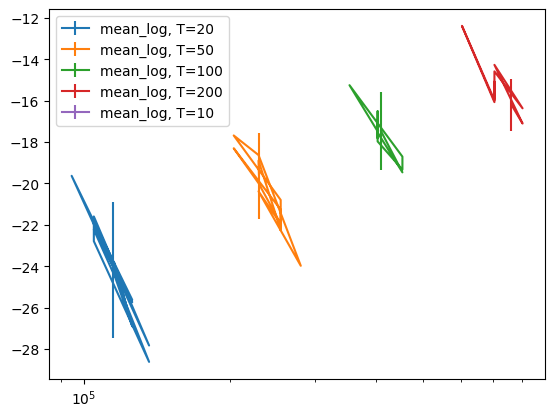

In [26]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MLS_Webb','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

